<a href="https://colab.research.google.com/github/emadphysics/Divulging-electricity-consumption-patterns/blob/main/facebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import zipfile
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import math
import seaborn as sns
from datetime import date
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import plotly.graph_objects as go
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import os

plt.style.use('bmh')
%matplotlib inline 

#sns.set_style("whitegrid")
#sns.set_context("poster")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [150]:
def error_metrics(y_pred, y_truth, model_name=None):
    dict_error = dict()

    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()

    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()


    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))


    R2 = r2_score(y_truth, y_pred)


    MAE = mean_absolute_error(y_truth, y_pred)


    MAPE = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)


    name = ['RMSE', 'R2', 'MAE', 'MAPE']
    value = [RMSE, R2, MAE, MAPE]

    a=pd.DataFrame(value,index=name,columns=[model_name])
    return a 
def plot_timeseries(ts, title = 'og', opacity = 1):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = ts.index, y = ts.values, name = "observed",
                         line_color = 'lightslategrey', opacity = opacity))

    fig.update_layout(title_text = title,
                  xaxis_rangeslider_visible = True)
    fig.show()
def plot_ts_pred(og_ts, pred_ts, model_name=None, og_ts_opacity = 0.5, pred_ts_opacity = 0.5):

    fig = go.Figure()

    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'deepskyblue', opacity = og_ts_opacity))

    try:
        fig.add_trace(go.Scatter(x = pred_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    except: 
        fig.add_trace(go.Scatter(x = og_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    fig.update_layout(title_text = 'Observed test set vs predicted energy MWH values using {}'.format(model_name),
                  xaxis_rangeslider_visible = True)
    fig.show()
def train_test(data, test_size = 0.15, scale = False, cols_to_transform=None, include_test_scale=False):

    df = data.copy()
    test_index = int(len(df)*(np.abs(1-test_size)))

    if scale and include_test_scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop('load', axis = 1).iloc[:test_index]
    y_train = df.load.iloc[:test_index]
    X_test = df.drop('load', axis = 1).iloc[test_index:]
    y_test = df.load.iloc[test_index:]

    if scale and not include_test_scale:
        scaler = StandardScaler()
        X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
        X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform])
    
    return X_train, X_test, y_train, y_test


In [64]:
df=pd.read_csv('/content/gdrive/My Drive/frame.csv',usecols=['load', 'hour', 'month', 'day', 'weekday', 'holiday',
       'non_working', 'season', 'temp','Date'],parse_dates=['Date'],index_col=['Date'])

In [8]:
#df.info()

In [65]:
cat_cols = ['non_working','weekday']

for col in cat_cols:
    df[col] = df[col].astype('category')

In [66]:
df_dum = pd.get_dummies(df, drop_first = True)

In [67]:
df_lag=df_dum.copy()

In [68]:
for i in range(24):
    df_lag['lag'+str(i+1)] = df_lag['load'].shift(i+1)

In [69]:
df_lag.dropna(inplace=True)

In [70]:
def add_fourier_terms(df, year_k, week_k, day_k):
    """
    df: dataframe to add the fourier terms to
    year_k: the number of Fourier terms the year period should have. Thus the model will be fit on 2*year_k terms (1 term for
    sine and 1 for cosine)
    week_k: same as year_k but for weekly periods
    day_k:same as year_k but for daily periods
    """

    for k in range(1, year_k + 1):
        # year has a period of 365.25 including the leap year
        df['year_sin' + str(k)] = np.sin(2 * k * np.pi * df.index.dayofyear / 365.25)
        df['year_cos' + str(k)] = np.cos(2 * k * np.pi * df.index.dayofyear / 365.25)

    for k in range(1, week_k + 1):
        # week has a period of 7
        df['week_sin' + str(k)] = np.sin(2 * k * np.pi * df.index.dayofweek / 7)
        df['week_cos' + str(k)] = np.cos(2 * k * np.pi * df.index.dayofweek / 7)

    for k in range(1, day_k + 1):
        # day has period of 24
        df['hour_sin' + str(k)] = np.sin(2 * k * np.pi * df.index.hour / 24)
        df['hour_cos' + str(k)] = np.cos(2 * k * np.pi * df.index.hour / 24)

In [71]:
df_lag

,load,hour,month,day,holiday,temp,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,non_working_Yes,season_spring,season_summer,season_winter,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00+00:00,33211.0,0,1,2,0,2.977,0,0,0,0,0,0,0,0,0,1,35981.0,39295.0,42254.0,43513.0,45459.0,46866.0,49197.0,50732.0,48347.0,47316.0,48270.0,47805.0,47675.0,41728.0,39733.0,37250.0,35709.0,34553.0,33167.0,32504.0,32624.0,33846.0,35827.0,37824.0
2015-01-02 01:00:00+00:00,31504.0,1,1,2,0,3.374,0,0,0,0,0,0,0,0,0,1,33211.0,35981.0,39295.0,42254.0,43513.0,45459.0,46866.0,49197.0,50732.0,48347.0,47316.0,48270.0,47805.0,47675.0,41728.0,39733.0,37250.0,35709.0,34553.0,33167.0,32504.0,32624.0,33846.0,35827.0
2015-01-02 02:00:00+00:00,30801.0,2,1,2,0,3.841,0,0,0,0,0,0,0,0,0,1,31504.0,33211.0,35981.0,39295.0,42254.0,43513.0,45459.0,46866.0,49197.0,50732.0,48347.0,47316.0,48270.0,47805.0,47675.0,41728.0,39733.0,37250.0,35709.0,34553.0,33167.0,32504.0,32624.0,33846.0
2015-01-02 03:00:00+00:00,31086.0,3,1,2,0,4.457,0,0,0,0,0,0,0,0,0,1,30801.0,31504.0,33211.0,35981.0,39295.0,42254.0,43513.0,45459.0,46866.0,49197.0,50732.0,48347.0,47316.0,48270.0,47805.0,47675.0,41728.0,39733.0,37250.0,35709.0,34553.0,33167.0,32504.0,32624.0
2015-01-02 04:00:00+00:00,33018.0,4,1,2,0,5.250,0,0,0,0,0,0,0,0,0,1,31086.0,30801.0,31504.0,33211.0,35981.0,39295.0,42254.0,43513.0,45459.0,46866.0,49197.0,50732.0,48347.0,47316.0,48270.0,47805.0,47675.0,41728.0,39733.0,37250.0,35709.0,34553.0,33167.0,32504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,51197.0,19,12,31,0,2.909,0,0,0,0,1,0,0,0,0,0,54069.0,56991.0,59634.0,57293.0,55947.0,55369.0,55588.0,56361.0,56971.0,56664.0,57613.0,56065.0,51848.0,47492.0,44191.0,42791.0,42669.0,43158.0,44127.0,45813.0,48329.0,51145.0,54402.0,57303.0
2019-12-31 20:00:00+00:00,48257.0,20,12,31,0,2.635,0,0,0,0,1,0,0,0,0,0,51197.0,54069.0,56991.0,59634.0,57293.0,55947.0,55369.0,55588.0,56361.0,56971.0,56664.0,57613.0,56065.0,51848.0,47492.0,44191.0,42791.0,42669.0,43158.0,44127.0,45813.0,48329.0,51145.0,54402.0
2019-12-31 21:00:00+00:00,46565.0,21,12,31,0,2.210,0,0,0,0,1,0,0,0,0,0,48257.0,51197.0,54069.0,56991.0,59634.0,57293.0,55947.0,55369.0,55588.0,56361.0,56971.0,56664.0,57613.0,56065.0,51848.0,47492.0,44191.0,42791.0,42669.0,43158.0,44127.0,45813.0,48329.0,51145.0


In [96]:
X_trainP, X_testP, y_trainP, y_testP = train_test\
                           (df_lag[['load', 'temp']], 
                           test_size=0.15, 
                           scale=False, #True
                           #cols_to_transform=cols_to_transform,
                           include_test_scale=False)

In [97]:
def data_prophet(X_train, X_test, y_train, y_test):
    data_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
    data_train = data_train.reset_index().rename(columns = {'load':'y', 'Date':'ds'})
    data_test = pd.merge(X_test, y_test, left_index=True, right_index=True)
    data_test  = data_test.reset_index().rename(columns = {'load':'y', 'Date':'ds'})
    return data_train, data_test

In [98]:
data_train, data_test = data_prophet(X_trainP, X_testP, y_trainP, y_testP)

In [75]:
from fbprophet import Prophet

In [101]:
prop = Prophet(growth='linear', interval_width = 0.95, 
                yearly_seasonality='auto',
                weekly_seasonality='auto',
                daily_seasonality='auto',
                seasonality_mode='additive',
              )

In [102]:
prop.add_regressor('temp', prior_scale=20, mode='additive', standardize=True)

In [107]:
data_train["ds"] =data_train["ds"].dt.strftime('%Y-%m-%d %H:%M:%S')

In [109]:
prop.fit(data_train)

In [110]:
future_dates = prop.make_future_dataframe(periods=len(data_test), freq='H', include_history=True)

In [114]:
data_train["ds"] =pd.to_datetime(data_train["ds"])

In [119]:
data_test["ds"] =pd.to_datetime(data_test["ds"])

In [127]:
data=data_train.append(data_test).drop('y', axis=1)

In [133]:
data["ds"] =pd.to_datetime(data["ds"],utc=True)
data["ds"] =data["ds"].dt.strftime('%Y-%m-%d %H:%M:%S')

In [136]:
data["ds"] =pd.to_datetime(data["ds"])

In [140]:
data.info(),future_dates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43800 entries, 0 to 6569
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      43800 non-null  datetime64[ns]
 1   temp    43800 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      43800 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 342.3 KB


(None, None)

In [141]:
future_dates = pd.merge(future_dates, data, on = 'ds')

In [142]:
future_dates.tail(3)

,ds,temp
43797,2019-12-31 21:00:00,2.210
43798,2019-12-31 22:00:00,1.785
43799,2019-12-31 23:00:00,1.444


In [143]:
forecast = prop.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
43795,2019-12-31 19:00:00,61986.493723,47754.356819,78568.254421
43796,2019-12-31 20:00:00,58717.175398,43141.723016,74325.278207
43797,2019-12-31 21:00:00,55159.868053,40806.798658,71139.126416
43798,2019-12-31 22:00:00,52023.814428,36691.110256,67988.005126
43799,2019-12-31 23:00:00,49624.506997,35069.633821,65786.008069


In [153]:
error_metrics(forecast.iloc[-len(data_test['y']):, ]['yhat'], data_test['y'], 
              'Face Book Prophet w\ auto seasonality')

,Face Book Prophet w\ auto seasonality
RMSE,4238.280016
R2,0.644327
MAE,3303.852207
MAPE,6.805881


In [155]:
drive.mount('drive')
error_metrics(forecast.iloc[-len(data_test['y']):, ]['yhat'], data_test['y'], 
              'Face Book Prophet w\ auto seasonality').to_csv('fb_result.csv')
!cp fb_result.csv "drive/My Drive/"              

Mounted at drive


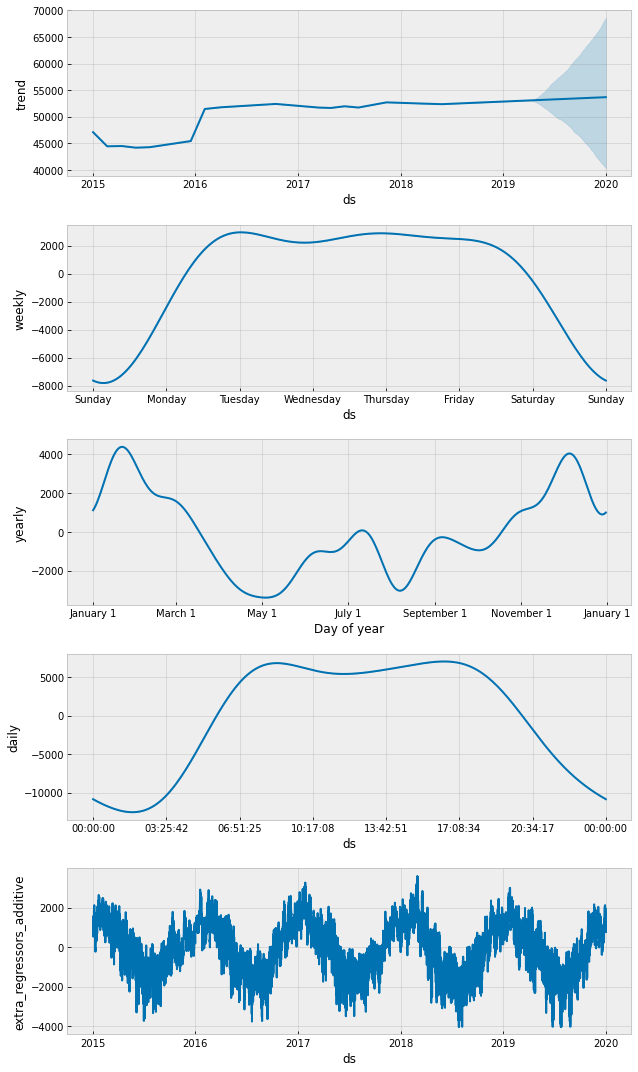

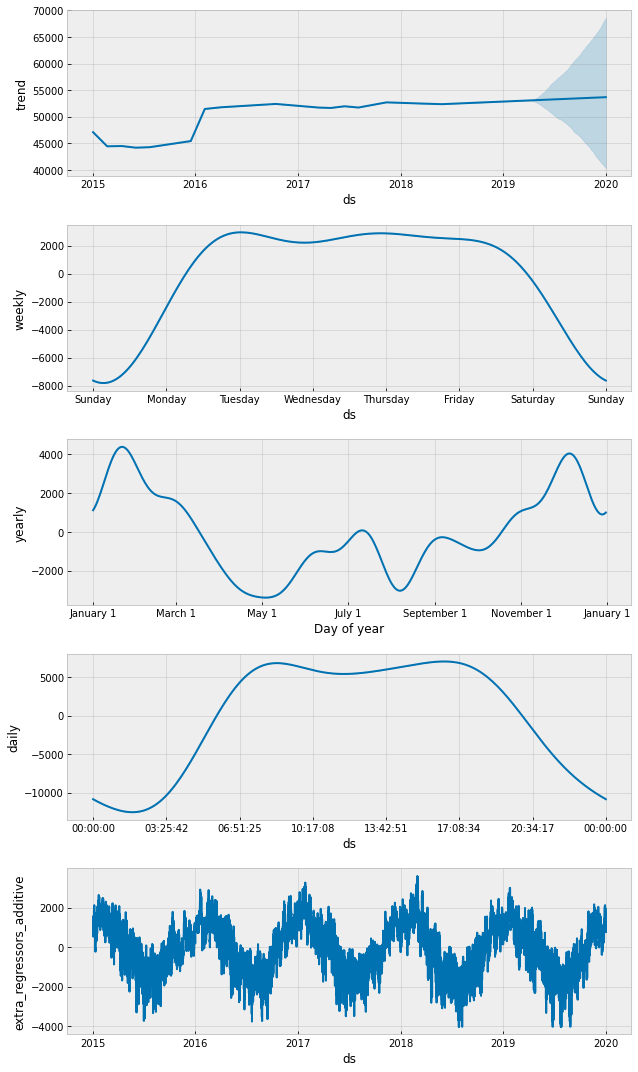

In [144]:
prop.plot_components(forecast)